# Ambient Populations

Some early experiments with 'ambient' population data from various sources to assess their use in COVID-19 related projects

## Initialisation

In [1]:
from bs4 import BeautifulSoup # requirement beautifulsoup4
from urllib.request import (
    urlopen, urlparse, urlunparse, urlretrieve)
import os, os.path
import sys
import pandas as pd
import numpy as np

## Leeds Footfall cameras

Leeds City Council run a network of 8 cameras that count the number of passers-by every hour. The data are publicly available on [Data Mill North](https://datamillnorth.org/dataset/leeds-city-centre-footfall-data).

We have already done quite a lot of analysis with those data elsewhere so wont repeat that here. 





### Download

Each month is reported in a different file, but it's quite easy to parse the html and get the urls for each file.

The next block saves each file in the directory [./data/lcc_footfall](./data/lcc_footfall) creating those directories if necessary.

If a file is already in that directory it doesn't re-dowload it.

In [2]:
data_dir = "./data/lcc_footfall" # Where to save the csv files
if not os.path.isdir(data_dir):
    print("Creating data directory {}".format(data_dir))
    os.makedirs(data_dir)

# Connect to the Data Mill North page and parse the html
root = 'https://datamillnorth.org/dataset/leeds-city-centre-footfall-data'
soup = BeautifulSoup(urlopen(root), 'html.parser')

# Iterate over all links and see which are csv files
for link in soup.find_all('a'):
    #print("\n****",link,"****\n")
    url = link.get('href')
    if url==None: # if no 'href' tag
        continue
    
    if url.endswith(".csv"):
        filename = url.strip().split("/")[-1] # File is last part of the url
        
        # For some reason some files are duplicated
        if filename.startswith("Copy") or filename.startswith("copy"): 
            continue
        # And we don't care about xmas analysis
        if filename.startswith("Christ"):
            continue
        
        # Save the csv file (unless it already exists already)
        full_path = os.path.join("./data/lcc_footfall",filename)
        if os.path.isfile(full_path):
            print("File {} exists already, not downloading".format(filename))
        else:
            print("Downloading {}".format(filename)) 
            csv_url = "https://datamillnorth.org/"+url
            data = pd.read_csv(csv_url)
            data.to_csv(full_path)

print("Finished")

File Mar%202020.csv exists already, not downloading
File Mar%202020.csv exists already, not downloading
File Mar%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20October%202019.csv exis

Read each of those files and create one big dataframe to store all the data.

In [3]:

def convert_hour(series):
    """Assumes the given series represents hours. Works out if they're 
    integers or in the format '03:00:00' and returns them as integers"""
    
    # If it's a number then just return it
    if isinstance(series.values[0], np.int64) or isinstance(series.values[0], np.float64) or isinstance(series.values[0], float):
        return series
    
    # If it's a string see if it can be made into a number
    try:
        int(series.values[0])
        return pd.to_numeric(series)
    except: # If get here then it couldn't be made into an integer
        pass
    
    if ":" in series.values[0]:
        return pd.to_numeric(series.apply(lambda x: x.strip().split(":")[0]))
    
    # If here then I don't know what to do.
    raise Exception("Unrecognised type of hours: {}".format(series))
    
# Template for our data frame. Set the type as well (default type is OK for 'location' and 'FileName')
template = pd.DataFrame(columns = ["Location", "Date", "Hour", "Count", "DateTime", "FileName"])
template.index
template["Date"] = pd.to_datetime(template["Date"], dayfirst=True)
template["Hour"] = pd.to_numeric(template["Hour"])
template["Count"] = pd.to_numeric(template["Count"])
template["DateTime"] = pd.to_numeric(template["DateTime"]) # (this one is derived from date and hour)

frames = [] # Build up a load of dataframes then merge them
total_rows = 0 # For checking that the merge works
files = [] # Remember the names of the files we tried to analyse
failures= [] # Remember which ones didn't work


# Read the files in
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        try:
            #print(filename)
            files.append(filename)
            df = pd.read_csv(os.path.join(data_dir,filename))
            
            # Check the file has the columns that we need, and work out what the column names are for this file (annoyingly it changes)
            date_col = "Date" # Doesn't change
            count_col = "Count" if "Count" in df.columns else "InCount" # Two options
            hour_col = "Hour" 
            loc_col = "Location" if "Location" in df.columns else "LocationName"
            
            if False in [date_col in df.columns, count_col in df.columns, hour_col in df.columns, loc_col in df.columns]:
                raise Exception("File '{}' is missing a column. Date? {}, Count? {}, Hour? {}, Location? {}".
                      format(filename, date_col in df.columns, count_col in df.columns, hour_col in df.columns, loc_col in df.columns))
                

            # Check if any of the columns have nans
            bad_cols = []
            for x in [date_col, count_col, hour_col, loc_col]:
                if True in df[x].isnull().values:
                   bad_cols.append(x)
            if len(bad_cols)>0:
                failures.append(filename)
                print(f"File {filename} has nans in the following columns: '{str(bad_cols)}'. Ignoring it")
                continue

            
            # Create Series' that will represent each column
            dates  = pd.to_datetime(df[date_col], dayfirst=True)
            counts = pd.to_numeric(df[count_col])
            hours  = convert_hour(df[hour_col]) # Hours can come in different forms 
            locs   = df[loc_col]
            
            # Derive a proper date from the date and hour
            # (Almost certainly a more efficient way to do this using 'apply' or whatever)
            dt     = pd.to_datetime(pd.Series( data = [date.replace(hour=hour) for date,hour in zip(dates,hours) ] ) )

            # Also useful to have the filename
            fnames = [filename for _ in range(len(df))]
            
            #df.apply(lambda x: x[date_col].replace(hour = x[hour_col]), axis=1)
            
            if False in [len(df) == len(x) for x in [dates, counts, hours, locs, dt]]:
                raise Exception("One of the dataframe columns does not have enough values")
            total_rows += len(df)
                
            
            # Create a temporary dataframe to represent the information in that file.
            # Note that consistent column names (defined above) are used
            frames.append(pd.DataFrame(data=
                    {"Location":locs, "Date":dates, "Hour":hours, 
                     "Count":counts, "DateTime":dt, "FileName":fnames}))
            
        except Exception as e:
            print("Caught exception on file {}".format(filename))
            raise e
            

# Finally megre the frames into one big one
merged_frames = pd.concat(frames)
if total_rows != len(merged_frames):
    raise Exception(f"The number of rows in the individual files {total_rows} does \
not match those in the final dataframe {len(merged_frames)}.")

df = template.append(merged_frames)            
print(f"Finished. Made a dataframe with {len(df)} rows. {len(failures)}/{len(files)} files could not be read.")

File Monthly%20Data%20Feed%20-%20%20Jan%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Dec%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Nov%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-April%202017%20-%2020170510.csv has nans in the following columns: '['Date', 'InCount', 'Hour', 'Location']'. Ignoring it
File Monthly%20Data%20Feed-Feb%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-March%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
Finished. Made a dataframe with 646294 rows. 6/58 files could not be read.


In [4]:
# Optionally save as a csv file for reading elsewhere
#df.to_csv("data/lcc_footfall_combined.csv")

### Sanity checks

Check there are no missing values

In [5]:
df.isnull().sum()

Location    0
Date        0
Hour        0
Count       0
DateTime    0
FileName    0
dtype: int64

Check that (locations, datetime) combinations are unique 

(https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count)

In [6]:
# Group by location and datetime, counting the number of occurrences
group = df.groupby(['Location','DateTime']).size().reset_index().rename(columns={0:'NumUniqueRows'})
if len(group[group.NumUniqueRows > 1]) > 1:
    print(f"There are {len(group[group.NumUniqueRows > 1])} non-unique location/datetime combinations")
    print(group[group.NumUniqueRows > 1])

There are 5760 non-unique location/datetime combinations
                   Location            DateTime  NumUniqueRows
138214  Albion Street South 2017-06-01 00:00:00              2
138215  Albion Street South 2017-06-01 01:00:00              2
138216  Albion Street South 2017-06-01 02:00:00              2
138217  Albion Street South 2017-06-01 03:00:00              2
138218  Albion Street South 2017-06-01 04:00:00              2
...                     ...                 ...            ...
632057              Headrow 2018-12-12 19:00:00              2
632058              Headrow 2018-12-12 20:00:00              2
632059              Headrow 2018-12-12 21:00:00              2
632060              Headrow 2018-12-12 22:00:00              2
632061              Headrow 2018-12-12 23:00:00              2

[5760 rows x 3 columns]


Join the group back to the original data to get the full information about each row

In [7]:
df2 = df.set_index(['Location','DateTime']).join(group.set_index((['Location','DateTime'])), how="left")
df2[df2.NumUniqueRows>1]

Date  ...  NumUniqueRows
Location            DateTime                        ...               
Albion Street South 2017-06-01 00:00:00 2017-06-01  ...              2
                    2017-06-01 00:00:00 2017-06-01  ...              2
                    2017-06-01 01:00:00 2017-06-01  ...              2
                    2017-06-01 01:00:00 2017-06-01  ...              2
                    2017-06-01 02:00:00 2017-06-01  ...              2
...                                            ...  ...            ...
Headrow             2018-12-12 21:00:00 2018-12-12  ...              2
                    2018-12-12 22:00:00 2018-12-12  ...              2
                    2018-12-12 22:00:00 2018-12-12  ...              2
                    2018-12-12 23:00:00 2018-12-12  ...              2
                    2018-12-12 23:00:00 2018-12-12  ...              2

[11520 rows x 5 columns]

And can find specific entiries like:

In [8]:
df[(df.DateTime==pd.to_datetime("2017-06-01 01:00:00")) & (df.Location=="Albion Street South")]

,Location,Date,Hour,Count,DateTime,FileName
1,Albion Street South,2017-06-01,1,28,2017-06-01 01:00:00,Monthy%20Data%20Feed%20-%20June%202017.csv
721,Albion Street South,2017-06-01,1,28,2017-06-01 01:00:00,Monthy%20Data%20Feed%20-%20June%202017.csv


I don't understand why there are duplicates. Part of this is errors in the csv files; e.g. `Monthy%20Data%20Feed%20-%20June%202017.csv` has duplicates for `Albion Street South`. 

For now just remove duplicates that have the same counts.

In [14]:
df_without_duplicates = df.drop_duplicates(subset=["Location", "DateTime", "Count"])
temp = df_without_duplicates.groupby(['Location','DateTime']).size().reset_index().rename(columns={0:'NumUniqueRows'})
print(f"There are {len(temp[temp.NumUniqueRows>1])} duplicates left")
if len(temp[temp.NumUniqueRows>1]) > 0:
    print(temp[temp.NumUniqueRows>1])
    raise Exception("Still have duplicates, should not continue")
# Make the change permanent
df.drop_duplicates(subset=["Location", "DateTime", "Count"], inplace=True)

There are 0 duplicates left


### Manual checking

Choose a few dates, times, locations and check the data in the dataframe match those in the raw files

In [16]:
#XXXX

### Plot Footfall

#### Sanity checking plots

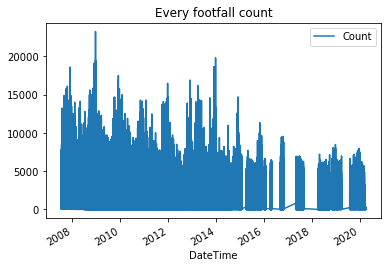

In [24]:
df.plot(x="DateTime", y="Count", title="Every footfall count")

In [ ]:
# XXXX PLOT THESE ON SAME FIGURE

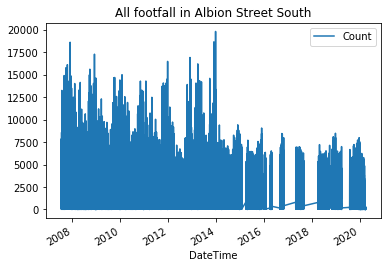

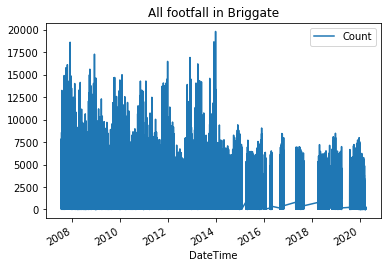

/Users/nick/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nick/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


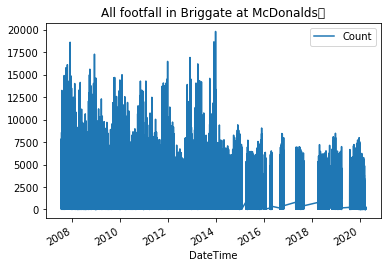

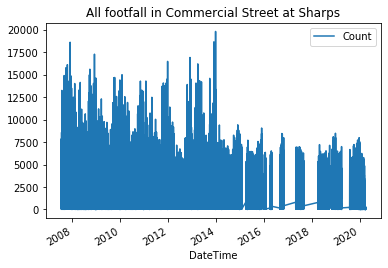

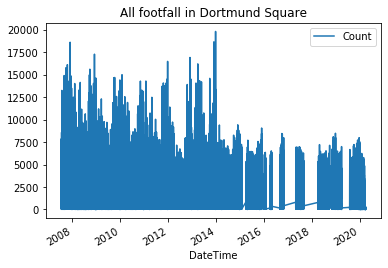

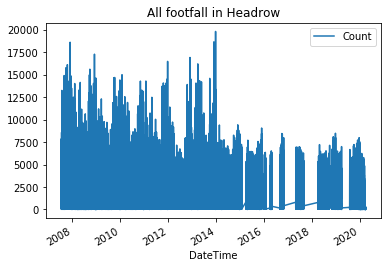

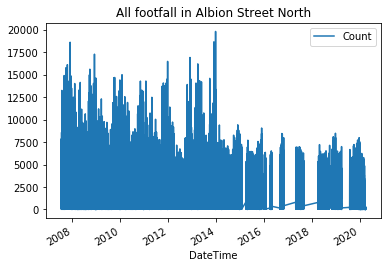

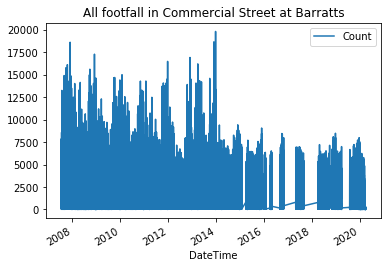

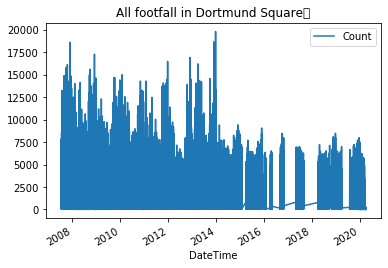

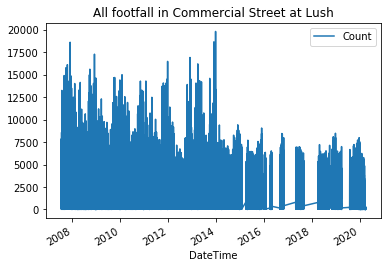

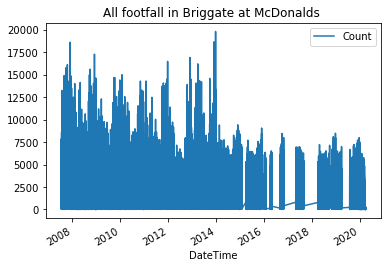

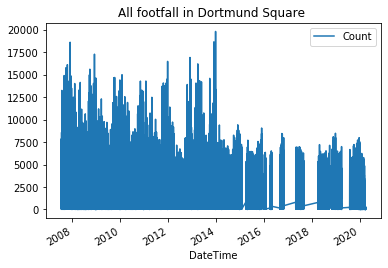

In [99]:
# plots for each location
for loc in df["Location"].unique():
    df.loc[ df.Location =="Briggate" , :].plot(x="DateTime", y="Count", title=f"All footfall in {loc}")

In [101]:
# Aggregate all locations ('DataFrameGrouped' = dfg)
dfg = df.groupby(['DateTime'])["Count"].sum()
dfg
# df.groupby(['DateTime'])["Count"].sum().reset_index().rename(columns={0:'NumUniqueRows'})
#df2 = df.groupby(by="Location").agg("Count")

DateTime
2007-07-20 00:00:00    251
2007-07-20 01:00:00    169
2007-07-20 02:00:00    173
2007-07-20 03:00:00     92
2007-07-20 04:00:00    114
                      ... 
2020-03-31 19:00:00    378
2020-03-31 20:00:00    277
2020-03-31 21:00:00    183
2020-03-31 22:00:00     88
2020-03-31 23:00:00     34
Name: Count, Length: 91176, dtype: int64

#### Weekly fotfall

(Some useful stuff [here](https://chrisalbon.com/python/data_wrangling/pandas_group_data_by_time/) on grouping by times)

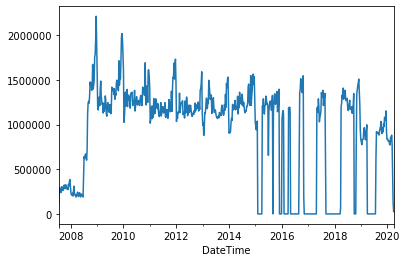

In [127]:
# (Sanity check that we're not loosing counts)
assert sum(dfg.resample('W').sum()) == sum(df["Count"])

dfg.resample('W').sum().plot()

In [77]:
#df_grouped = df.groupby(by=["Location", "DateTime"])
df2 = df.set_index("DateTime")
df2.groupby(by=[df2.index.month, df2.index.year]).agg("Count")

## Newcastle Urban Observatory

## Twitter
